In [1]:
import os
import glob 

files = glob.glob('*.DTA')
files


['3 CV 300_M1_S2_test2_cdl.DTA']

In [2]:
ch = 0

filename = files[ch]
filename

'3 CV 300_M1_S2_test2_cdl.DTA'

In [3]:
import numpy as np  # For creating arrays (optional)
import pandas as pd


# File path (replace with your actual file path)

# Define the line number to start reading (skip header lines)
start_line = 65  # For example, skip the first 5 lines (adjust as needed)

# Initialize variables to store curves
curves = []
current_curve = []

# Open and read the file
with open(filename, "r") as file:
    # Skip lines until the start_line
    for i, line in enumerate(file):
        if i < start_line:
            continue  # Skip header lines
        
        line = line.strip()  # Remove leading/trailing spaces
        
        # If the line starts with "CURVE", we've reached a new curve
        if line.startswith("CURVE"):
            # If there's an existing curve, add it to the list (as a numpy array)
            if current_curve:
                # Process each line of the curve before adding it to the curves list
                processed_curve = []
                for curve_data in current_curve:
                    # Replace commas with periods
                    curve_data = curve_data.replace(',', '.')
                    # Split by tab (\t)
                    processed_curve.append(curve_data.split('\t'))
                
                # Append the processed curve to curves
                curves.append(np.array(processed_curve))  # Convert to array (optional)
                current_curve = []  # Reset for the next curve

        
        # Skip lines with "\tPt" (data header)
        elif line.startswith("Pt"):
            pass

            # Skip lines with "\t#" (unit header)
        elif line.startswith("#"):
            pass   

        else:
            # Add the line to the current curve if it's part of the curve data
            current_curve.append(line)
    

    # Add the last curve to the list (if exists)
    if current_curve:
        processed_curve = []
        for curve_data in current_curve:
            # Replace commas with periods
            curve_data = curve_data.replace(',', '.')
            # Split by tab (\t)
            processed_curve.append(curve_data.split('\t'))
        
        # Append the processed curve to curves
        curves.append(np.array(processed_curve, dtype=object))  # Convert to array


Convert the curve in the curves list into a dataframes. Splitting each curve into a dataframe

In [4]:
import pandas as pd

# Assuming 'curves' is a list of curves (each curve is a list of lists or a numpy array)
curve_dfs = {}  # Dictionary to store each curve as a separate DataFrame

for i, curve in enumerate(curves, 1):
    # print(f"Curve {i}:")
    # print(curve)  # This will print each curve's data as it's processed
    
    # Convert the curve into a DataFrame
    aux = pd.DataFrame(curve)
    
    # If you want to set meaningful column names, you can do so here
    # Replace this with appropriate names based on your data
    column_names = [f'Column_{j+1}' for j in range(aux.shape[1])]  # Creates a list of column names
    aux.columns = column_names
    
    # Store the DataFrame in the dictionary using a unique key for each curve
    curve_dfs[f'Curve_{i}'] = aux

# Now each curve is stored as a separate DataFrame in the 'curve_dfs' dictionary
# You can access them like this:
# curve_dfs['Curve_1'], curve_dfs['Curve_2'], ...

# Example: Print the first few rows of each curve DataFrame
for curve_name, curve_df in curve_dfs.items():
    print(f"\n{curve_name}:")
    print(curve_df.head())  # Display the first 5 rows of each curve


Curve_1:
  Column_1  Column_2       Column_3       Column_4      Column_5  \
0        0  0.006667  -7.64853E-005  -2.67635E-004  0.00000E+000   
1        1  0.013333   1.92204E-003  -2.00121E-004  0.00000E+000   
2        2      0.02   3.92206E-003  -1.60665E-004  0.00000E+000   
3        3  0.026667   5.92171E-003  -1.29566E-004  0.00000E+000   
4        4  0.033333   7.92136E-003  -1.04228E-004  0.00000E+000   

       Column_6      Column_7 Column_8     Column_9 Column_10  
0  5.50598E-006  0.00000E+000        9  ...........   1359.17  
1  2.00452E-003  0.00000E+000        9  ...........   1359.17  
2  4.00353E-003  0.00000E+000        9  ...........   1359.17  
3  6.00255E-003  0.00000E+000        9  ...........   1359.17  
4  8.00156E-003  0.00000E+000        9  ...........   1359.17  

Curve_2:
  Column_1 Column_2      Column_3       Column_4      Column_5      Column_6  \
0      147  0.98667  9.39197E-002  -2.10196E-004  0.00000E+000  9.39966E-002   
1      148  0.99333  9.1915

In [10]:
from scipy.signal import savgol_filter

# Iterate over each curve DataFrame in the dictionary and select columns 2, 3, and 4
selected_columns = {}

for curve_name, curve_df in curve_dfs.items():
    # Select columns 2, 3, and 4 (which are indices 1, 2, and 3)
    selected = curve_df.iloc[:, [1, 2, 3]]
    
    # Assign the new column names: "Time", "Vf", "A"
    selected.columns = ['Time', 'Vf', 'A']
    
    # Convert the selected columns to float
    selected = selected.astype(float)
    
    # Apply Savitzky-Golay filter for smoothing
    window_size = 20  # Window size (must be odd)
    poly_order = 3    # Polynomial order for the filter

    selected['Vf_smooth'] = savgol_filter(selected['Vf'], window_size, poly_order)
    selected['A_smooth'] = savgol_filter(selected['A'], window_size, poly_order)
    
    # Store the selected columns with new names and smoothed data in the dictionary
    selected_columns[curve_name] = selected

    # Print the first 5 rows to verify
    print(f"\nSelected and smoothed columns for {curve_name}:")
    print(selected_columns[curve_name].head())

# Now, selected_columns dictionary contains the original and smoothed data for each curve
# Access them like this: selected_columns['Curve_1'], selected_columns['Curve_2'], ...



Selected and smoothed columns for Curve_1:
       Time        Vf         A  Vf_smooth  A_smooth
0  0.006667 -0.000076 -0.000268  -0.000041 -0.000247
1  0.013333  0.001922 -0.000200   0.001924 -0.000204
2  0.020000  0.003922 -0.000161   0.003904 -0.000169
3  0.026667  0.005922 -0.000130   0.005896 -0.000140
4  0.033333  0.007921 -0.000104   0.007897 -0.000116

Selected and smoothed columns for Curve_2:
      Time        Vf         A  Vf_smooth  A_smooth
0  0.98667  0.093920 -0.000210   0.093917 -0.000210
1  0.99333  0.091916 -0.000212   0.091918 -0.000213
2  1.00000  0.089917 -0.000216   0.089918 -0.000216
3  1.00667  0.087915 -0.000218   0.087918 -0.000218
4  1.01333  0.085918 -0.000221   0.085918 -0.000221


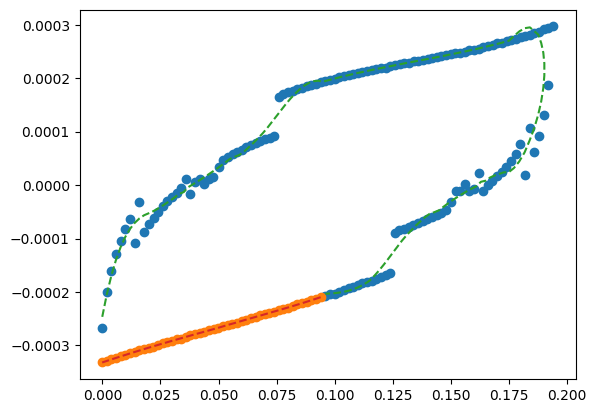

In [11]:
# from scipy import signal
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

plt.plot(selected_columns['Curve_1']['Vf'],selected_columns['Curve_1']['A'],'o')
plt.plot(selected_columns['Curve_2']['Vf'],selected_columns['Curve_2']['A'],'o')

plt.plot(selected_columns['Curve_1']['Vf_smooth'],selected_columns['Curve_1']['A_smooth'],'--')
plt.plot(selected_columns['Curve_2']['Vf_smooth'],selected_columns['Curve_2']['A_smooth'],'--')

In [12]:
# Specify the filename where the Excel file will be saved
name = filename + "_sbs.xlsx"

# Use ExcelWriter to write multiple DataFrames into one Excel file
with pd.ExcelWriter(name) as writer:
    for curve_name, df in selected_columns.items():
        # Write each DataFrame into a separate sheet
        df.to_excel(writer, sheet_name=curve_name, index=False)

print(f"DataFrames saved to {name}")


DataFrames saved to 3 CV 300_M1_S2_test2_cdl.DTA_sbs.xlsx
